# Training Decision Transformers with 🤗 transformers

In this tutorial, **you’ll learn to train your first Offline Decision Transformer model from scratch to make a half-cheetah run.** 🏃

❓ If you have questions, please post them on #study-group discord channel 👉 https://discord.gg/aYka4Yhff9

🎮 Environments:
- [Half Cheetah](https://www.gymlibrary.dev/environments/mujoco/half_cheetah/)

⬇️ Here's what you'll achieve at the end of this tutorial. ⬇️

### Prerequisites 🏗️
Before diving into the notebook, you need to:

🔲 📚 [Read the tutorial](https://huggingface.co/blog/train-decision-transformers)

### Step 1: Install dependencies for model evaluation 🔽

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common \
    patchelf \
    xvfb

### Step 2: Install and import the packages 📦



In [ ]:
!pip install gym==0.21.0
!pip install free-mujoco-py

!pip install datasets
!pip install imageio-ffmpeg

# !pip install colabgymrender==1.0.2
!pip install xvfbwrapper
!pip install imageio==2.4.1
!pip install imageio-ffmpeg
!pip install huggingface_hub
!pip install rover_arm==1.1.11
!pip install transformers==4.28.0

In [ ]:
import os
import random
from dataclasses import dataclass
import gym
import numpy as np
import torch
from datasets import load_dataset
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments
import gym
from datasets import Dataset
import datasets



```
# This is formatted as code
```

### Step 3: Loading the dataset from the 🤗 Hub and instantiating the model

We host a number of Offline RL Datasets on the hub. Today we will be training with the halfcheetah “expert” dataset, hosted here on hub.

First we need to import the load_dataset function from the 🤗 datasets package and download the dataset to our machine.

In [ ]:
os.environ["WANDB_DISABLED"] = "true" # we diable weights and biases logging for this tutorial
# dataset = load_dataset("edbeeching/decision_transformer_gym_replay", "halfcheetah-expert-v2")


In [ ]:
# type(dataset["train"]), type(dataset)

#### Step 3.1: Generating Dataset 

In [ ]:
import rover_arm
env = gym.make('rover-arm-pick-v0')

In [ ]:
# def collect_data(env, max_steps = 100):
#     _, info = env.reset()
#     obses, actions, rews, dones = [], [], [], []
#     # obs = env.render() # use visual input this time!
#     for i in range(max_steps):
#         action = env.action_space.sample()
#         obs , reward, done, info = env.step(action)
#         # observation = env.render()
#         obses.append(obs)
#         actions.append(action)
#         rews.append(reward)
#         dones.append(done)
#         if done:
#             obs, info = env.reset()
#             break
#     return obses, actions, rews, dones

In [ ]:
# np.array(dataset['train']['observations']).shape

In [ ]:
# # dataset = load_dataset("edbeeching/decision_transformer_gym_replay", "halfcheetah-expert-v2")

# # print(dataset["train"])
# # print(len(dataset["train"]))
# # print(dataset["train"][0])
# # print(len(dataset["train"][0]['observations']))
# # print(len(dataset["train"][0]['observations'][0]))


# EPISODES = 100
# MAX_STEPS = 5000
# collected_data = []
# for i in range(EPISODES):
#     print(f"Ep {i}")
#     data = collect_data(env, MAX_STEPS)
#     collected_data.append(data)
    

# train_data = {
#             'observations' : [data[0] for data in collected_data],
#             'actions' : [data[1] for data in collected_data],
#             'rewards' : [data[2] for data in collected_data],
#             'dones' : [data[3] for data in collected_data]
#         }


# train_dataset = datasets.arrow_dataset.Dataset.from_dict(train_data)
# dataset = datasets.DatasetDict({"train":train_dataset})


# print(dataset["train"])
# print(len(dataset["train"]))
# print(dataset["train"][0])
# print(len(dataset["train"][2]['observations']))
# print(len(dataset["train"][0]['observations'][0]))



In [ ]:
# print(len(dataset["train"][0]['rewards']))
# len(dataset["train"][1]['rewards'])

In [ ]:
# !rm -r /content/Data
!unzip /content/Dataset.zip -d /content/

In [ ]:
# dataset.save_to_disk("/content/Dataset/")

# !zip -r /content/rover_arm_dataset.zip /content/Dataset
# from google.colab import files
# files.download("/content/rover_arm_dataset.zip")


In [ ]:
# !export CUDA_VISIBLE_DEVICES=""

In [ ]:
import datasets
dataset = datasets.load_from_disk("/content/Dataset")
dataset

In [ ]:
# torch.cuda.is_available()

### Step 4: Defining a custom DataCollator for the transformers Trainer class

In [ ]:
@dataclass
class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 50 #subsets of the episode we use for training
    state_dim: int = 14  # size of state space
    act_dim: int = 6  # size of action space
    max_ep_len: int = 4000 # max episode length in the dataset
    scale: float = 1.0  # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = len(dataset[0]["actions"][0])
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        # calculate dataset stats for normalization of states
        states = []
        traj_lens = []
        for obs in dataset["observations"]:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
        
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(
            np.arange(self.n_traj),
            size=batch_size,
            replace=True,
            p=self.p_sample,  # reweights so we sample according to timesteps
        )
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # for feature in features:
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature["rewards"]) - 1)

            # get sequences from dataset
            s.append(np.array(feature["observations"][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature["actions"][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature["rewards"][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature["dones"][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature["rewards"][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

### Step 5: Extending the Decision Transformer Model to include a loss function

In order to train the model with the 🤗 trainer class, we first need to ensure the dictionary it returns contains a loss, in this case L-2 norm of the models action predictions and the targets.

In [ ]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        loss = torch.mean((action_preds - action_targets) ** 2)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [ ]:
collator = DecisionTransformerGymDataCollator(dataset["train"])

config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = TrainableDT(config)
# model = TrainableDT.from_pretrained("/content/model")

### Step 6: Defining the training hyperparameters and training the model
Here, we define the training hyperparameters and our Trainer class that we'll use to train our Decision Transformer model.

This step takes about an hour, so you may leave it running. Note the authors train for at least 3 hours, so the results presented here are not as performant as the models hosted on the 🤗 hub.

In [ ]:
# pip install --upgrade accelerate

In [ ]:
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=1000,
    per_device_train_batch_size=64,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    data_collator=collator,
)

trainer.train()

In [ ]:
trainer.save_model("/content/model")

In [ ]:
!zip -r /content/model.zip /content/model

In [ ]:
# pip install --upgrade accelerate

### Step 7: Visualize the performance of the agent

In [ ]:
# import mujoco_py


# from colabgymrender.recorder import Recorder

In [ ]:
# Function that gets an action from the model using autoregressive prediction with a window of the previous 20 timesteps.
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]

In [ ]:
import imageio
from IPython.display import Image, display
from io import BytesIO

# Code for visualizing the episode
from IPython.display import HTML
from base64 import b64encode

class GIFMaker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.buffer = BytesIO()
  
    def append(self, img):
        n_channels = img.shape[2]
        imgs = []
        for i in range(n_channels // 3):
            imgs.append(img[:,:,i * 3: (i + 1) * 3])
        self.images.append(np.hstack(imgs))

    def display(self, fname = "out", fps = 10, nframes = 200):
        if len(self.images) == 0:
            return
        imageio.mimsave(f'./{fname}.mp4', self.images[:nframes], 'mp4', fps=fps)
        mp4 = open(f'./{fname}.mp4','rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        html = HTML("""
        <video width=400 controls>
            <source src="%s" type="video/mp4">
        </video>
        """ % data_url)
        display(html)
    def video_out(self, fname = "out", fps = 10, nframes = None):
        if len(self.images) == 0:
            return
        imageio.mimsave(f'./{fname}.mp4', self.images[:nframes], 'mp4', fps=fps)
        mp4 = open(f'./{fname}.mp4','rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        html = HTML("""
        <video width=400 controls>
            <source src="%s" type="video/mp4">
        </video>
        """ % data_url)
        return html

    def __len__(self):
      return len(self.images)

In [ ]:
# env.render(mode = 'human')

In [ ]:
# build the environment
directory = './video'
model = model.to("cpu")
env = gym.make("rover-arm-pick-v0")
# env = Recorder(env, directory, fps=1)
max_ep_len = 4000
device = "cpu"
scale = 1.  # normalization for rewards/returns
TARGET_RETURN = 1.2 / scale  # evaluation is conditioned on a return of 12000, scaled accordingly

state_mean = collator.state_mean.astype(np.float32)
state_std = collator.state_std.astype(np.float32)
print(state_mean)

state_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
# Create the decision transformer model

state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)


In [ ]:
# Interact with the environment and create a video
episode_return, episode_length = 0, 0
state, _ = env.reset()
g = GIFMaker()
target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
rewards = torch.zeros(0, device=device, dtype=torch.float32)

timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
for t in range(max_ep_len*2):
    actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
    rewards = torch.cat([rewards, torch.zeros(1, device=device)])

    action = get_action(
        model,
        (states - state_mean) / state_std,
        actions,
        rewards,
        target_return,
        timesteps,
    )
    actions[-1] = action
    action = action.detach().cpu().numpy()

    state, reward, done, _ = env.step(action)
    
    img = env.render(width = 224, height = 224)
    if t % 100 == 0:
        print(t, episode_return, len(g.images))
    g.append(img)
    

    cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
    states = torch.cat([states, cur_state], dim=0)
    rewards[-1] = reward

    pred_return = target_return[0, -1] - (reward / scale)
    target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
    timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

    episode_return += reward
    episode_length += 1

    if done:
        break


In [ ]:
g.video_out(fps = 60)
# reward, episode_length

In [ ]:
 # Play the video
# env.play()
# # If you want to convert the video:
# !ffmpeg -i /content/video/1683735925.3753946.mp4 -vcodec h264 replay.mp4 

### Step 8: Publish our trained model on the Hub 🔥
Now that we saw we got good results after the training, we can publish our trained model on the hub 🤗 with one line of code.

Under the hood, the Hub uses git-based repositories (don't worry if you don't know what git is), which means you can update the model with new versions as you experiment and improve your agent.

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

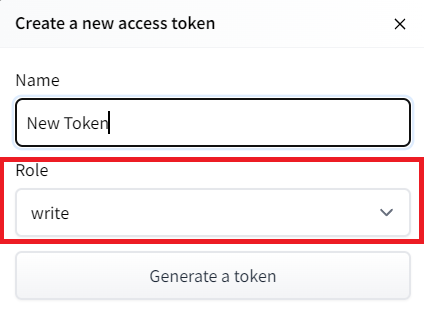

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

3️⃣ We're now ready to push our trained model to the 🤗 Hub 🔥 !!

In [ ]:
# trainer.push_to_hub()

## Some additional challenges 🏆
Congratulations, you've just trained your first Decision Transformer 🥳.

Now, the best way to learn **is to try things by your own**! Why not trying with another environment?

We provide datasets for some other environments:
* [Walker2D](https://huggingface.co/edbeeching/decision-transformer-gym-walker2d-expert)
* [Hopper](https://huggingface.co/edbeeching/decision-transformer-gym-hopper-expert)


Have fun!

### Keep Learning, Stay awesome 🤗
